In [31]:
import torch
from torch_geometric.nn.unpool import knn_interpolate

from torch_geometric.data import Data

from torch_geometric.nn import MLP
from torch_geometric.nn.models import MLP
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn
import time


In [32]:
# prepare mean_airfoil data
from nsres_data import *
theta_rot = 45
theta_seg = 90
dsdf_inf = 4.0
case = '/home/jessica/Downloads/submission/AirfRANS/mean_airfoil_HR/'
s = case.split('/')[-1]
Uinf, alpha = 1,1
# _iter = get_lastIteration(case)
# preprocess(case)
mesh = Ofpp.FoamMesh(case)
cC = get_cellCentres(mesh,case)
xlim = [-2, 4]
ylim= [-1.5, 1.5]
_include = (cC[:,0]>=xlim[0]) & (cC[:,0]<=xlim[1]) \
            & (cC[:,1]>=ylim[0]) & (cC[:,1]<=ylim[1])

points = []
inverted_index = {}
count = 0
for i,boolean in enumerate(_include):
    if boolean:
        # boolean2 = mesh.is_cell_on_boundary(i,b'aerofoil')
        # surfbool.append(boolean2)
        inverted_index[i] = count
        count+=1
surf_magSf, surf_mid, norm = compute_normalOutward(case,cC,normal_source=True,magSf = True)
# _, _, norm_unnormalized = compute_normalOutward(case,cC,normal_source=True, unit_normal = False, magSf = True)
surf_nodexy = [] # Cf
for i,boolean in enumerate(_include):
    if (boolean):
        ipos = inverted_index[i] # reindexed position
        bool2 = mesh.is_cell_on_boundary(i,b'aerofoil')
        if bool2:
            surf_nodexy.append([surf_mid[i][0],surf_mid[i][1]])
        points.append([cC[i,0],cC[i,1]])
        
surfbool = np.array([False]*len(points) + [True]*len(surf_nodexy))
points = np.concatenate([points,np.array(surf_nodexy)],axis = 0) 
mean_data = Data(pos = torch.tensor(points),surf=torch.tensor(surfbool))
mean_data.saf = GcomputeSAF2(pos = mean_data.pos.clone(), surf_bool = mean_data.surf)

In [21]:
# mean_data
# torch.save(mean_data,'mean_airfoil.pkl')

In [33]:
mean_data

Data(pos=[171950, 2], surf=[171950], saf=[171950, 2])

In [34]:
# new plan: MLP to estimate whole u,v,p,nut fields from parameters
# (estimate onto a "mean field", then interpolate onto field of interest)
# then use MLP output as estimate to add to residual field from GUNet
# ------

# step 1: define interpolation function

def getBonA(airfoilA, airfoilB):
    '''interpolate airfoil B y values onto the positions of airfoil A nodes
    based on SDF and SAF values of A and B'''
    #interpolate B onto the node positions of A using the x,y position coor.
    # B_inter_f = knn_interpolate(B_f, airfoilB.pos, airfoilA.pos, \
    #                             batch_x=airfoilB.batch, k=3)
    
    ####### OR, interpolate based on SDF and SAF rather than pos!!! #######
    A_sdaf = torch.stack([torch.norm(airfoilA.saf, dim=1), \
                          torch.atan2(airfoilA.saf[:,0],airfoilA.saf[:,1])],dim=1)
    B_sdaf = torch.stack([torch.norm(airfoilB.saf, dim=1), \
                          torch.atan2(airfoilB.saf[:,0],airfoilB.saf[:,1])],dim=1)
    B_inter_f = knn_interpolate(airfoilB.y, B_sdaf, A_sdaf, \
                                batch_x=airfoilB.batch, k=3)
    return B_inter_f


In [35]:
import json,os
from tqdm import tqdm
with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
    
train = manifest['scarce_train']
test = manifest['full_test']

train_set = [torch.load(os.path.join('nsresd/',airfoilA+'.pkl')) for airfoilA in tqdm(train)]
test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]

def parameters_of(s):
    Uinf, alpha = float(s.split('_')[2]), float(s.split('_')[3])
    if len(s.split('_')[4:]) == 4:
        digit1,digit2,digit3,digit45 = [float(i) for i in s.split('_')[4:]]
        # assert digit3>=0
        characteristic = (Uinf,alpha, digit1,digit2,digit3,digit45)
        # characteristic = (Uinf,alpha, digit1,digit2,digit45)
    else:
        digit1,digit2,digit34 = [float(i) for i in s.split('_')[4:]]
        # characteristics.append((Uinf,alpha,digit1,digit2,-1,digit34))
        characteristic = (Uinf,alpha,digit1,digit2,-1,digit34)
    return characteristic

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.48it/s]


In [36]:
# step 2: obtain MLP training data.
# we will need to interpolate all airfoils onto the same mean airfoil mesh

train_MLPset = []
#mean_airfoil = torch.load('mean_airfoil.pkl') #mean_airfoil is data object with pos and saf variables
mean_airfoil = mean_data
for airfoil_name, airfoilB in zip(train,train_set):
    inputx = parameters_of(airfoil_name)
    output = getBonA(mean_airfoil,airfoilB)

    data = Data(x=torch.tensor(inputx).to(torch.float32), y=output.to(torch.float32))
    train_MLPset.append(data)

In [72]:
print(train_MLPset[0].y)

tensor([[ 3.5938e+01,  6.0730e+00,  6.6674e+00,  1.9217e-08],
        [ 3.5933e+01,  6.0080e+00,  7.2570e+00,  2.1493e-07],
        [ 3.5925e+01,  5.9404e+00,  7.9069e+00,  2.9909e-07],
        ...,
        [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00]])


In [37]:
# step 3: define MLP and MLP training functions

# READ (about optimisers and schedulers): https://pytorch.org/docs/stable/optim.html
##############################
##### estUPNut CLASS DEF #####
##############################
#estUPNut CLASS codes, using MLP.

class estUPNut(torch.nn.Module):
    def __init__(self, layers=[14,28,125,500,2000,8000,32000], dropout=0.3):
        super(estUPNut, self).__init__()
        self.layers = MLP(layers,dropout=0.3)

    def forward(self, batch):
        # print(batch)
        x = self.layers(batch.x.clone().unsqueeze(0))
        return x, batch.y


In [164]:
##############################
### estUPNutfit CLASS DEF ####
##############################
#estUPNutfit CLASS: fit() func
class estUPNutfit:
    def __init__(self, layers=[6,171950*4], dropout=0.3, device='cuda:0'):
        self.model = estUPNut(layers, dropout=dropout)

        if torch.cuda.device_count() > 1:
            self.model = DataParallel(self.model)
        self.model.to(device); 
        self.device=device; 
        self.mean,self.var = None,None
        self.tb = SummaryWriter() #tensorboard --logdir=runs

    def fit(self, dataset, max_epoch=100, bs=3, L1=10, lr=5, weight_decay=1e-6, verbose=True):
        criterion = nn.MSELoss().to(self.device);
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)
        
        self.model.train() #force dropouts to occur.
        start=time.time(); #print(self.model);
        self.tb = SummaryWriter() #TensorBoard to show progress

        scaler = torch.cuda.amp.GradScaler() #ADDED: half pres
        for epoch in tqdm(range(max_epoch)):
            running_loss=0; num_batches=0
            # create minibatches
            #trainLoader = DataLoader(dataset, batch_size=bs, shuffle=True)
            trainLoader = DataListLoader(dataset, batch_size=bs, shuffle=True)
            Losslist = []
            for batch_list in trainLoader:
                #batch = batch.to(self.device)
                optimizer.zero_grad() #ADDED

                # do one step of stochastic gradient descent: U=U-lr(dL/dU)
                with torch.cuda.amp.autocast(): #ADDED: half pres
                    self.model.eval()
                    # print(batch_list)
                    outputs, GTy = self.model(batch_list)
                    outputs = outputs.reshape(GTy.shape)
                    # print(batch_list)
                    # --
                    surf_bools = torch.cat([mean_data.surf for data_clone in batch_list],0).to(self.device)
                    loss_surf_var = criterion(outputs[surf_bools,:], GTy[surf_bools,:]).mean()
                    loss_vol_var = criterion(outputs[~surf_bools, :], GTy[~surf_bools, :]).mean()
                    loss = (1/2)*(loss_vol_var + loss_surf_var)
                    # --
                    # loss = criterion(outputs, GTy).mean()
                    if torch.isinf(loss).item() is True:
                        print("loss: ",loss.item()," outputs: ",outputs," inputs: ",inputs)
                    scaler.scale(loss).backward() #ADDED: half pres
                    # nn.utils.clip_grad_norm_(self.model.parameters(), 5) #if nan loss!
                    scaler.step(optimizer) #ADDED: half pres
                    scaler.update() #ADDED: half pres

                    # add the loss of this batch to the running loss
                    # running_loss += loss.detach().item(); 
                    Losslist.append(loss.detach().item())
                    num_batches+=1
            # break
            # compute stats for the full training set
            scheduler.step() #anneal lr
            total_loss = torch.sum(torch.tensor(Losslist)/num_batches).item(); elapsed = time.time()-start
            self.tb.add_scalar("Loss/Epoch", total_loss, epoch) #TB plot loss
            # print(Losslist)
            if verbose & (epoch%5 == 0):
                #print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
                print('epoch=',epoch,'\t time=',elapsed,'\t loss=',total_loss)

        self.tb.close #Tensorboard close
        return self

In [167]:
# step 4: train the MLP
from torch_geometric.nn import DataParallel
from torch_geometric.data import DataListLoader
trainedMSD = estUPNutfit(device = 'cuda:0')
trainedMSD = trainedMSD.fit(train_MLPset,max_epoch = 200,lr = 100)
torch.save(trainedMSD.model.module,'estUPNut1')

  0%|▍                                                                                 | 1/200 [00:01<03:26,  1.04s/it]

epoch= 0 	 time= 1.0398533344268799 	 loss= 16081221.0


  3%|██▍                                                                               | 6/200 [00:06<03:14,  1.00s/it]

epoch= 5 	 time= 6.018593788146973 	 loss= 3088118.25


  6%|████▍                                                                            | 11/200 [00:10<03:07,  1.01it/s]

epoch= 10 	 time= 10.955342054367065 	 loss= 3087212.5


  8%|██████▍                                                                          | 16/200 [00:16<03:11,  1.04s/it]

epoch= 15 	 time= 16.194581270217896 	 loss= 2324175.5


 10%|████████▌                                                                        | 21/200 [00:21<03:00,  1.01s/it]

epoch= 20 	 time= 21.236424922943115 	 loss= 2904892.5


 13%|██████████▌                                                                      | 26/200 [00:26<02:50,  1.02it/s]

epoch= 25 	 time= 26.095043420791626 	 loss= 2098766.5


 16%|████████████▌                                                                    | 31/200 [00:31<02:51,  1.02s/it]

epoch= 30 	 time= 31.21929693222046 	 loss= 2237543.25


 18%|██████████████▌                                                                  | 36/200 [00:36<02:45,  1.01s/it]

epoch= 35 	 time= 36.29005002975464 	 loss= 2027757.75


 20%|████████████████▌                                                                | 41/200 [00:41<02:35,  1.02it/s]

epoch= 40 	 time= 41.212053298950195 	 loss= 2037694.75


 23%|██████████████████▋                                                              | 46/200 [00:46<02:34,  1.00s/it]

epoch= 45 	 time= 46.1811089515686 	 loss= 2274770.75


 26%|████████████████████▋                                                            | 51/200 [00:51<02:28,  1.01it/s]

epoch= 50 	 time= 51.161858320236206 	 loss= 2599648.25


 28%|██████████████████████▋                                                          | 56/200 [00:56<02:27,  1.02s/it]

epoch= 55 	 time= 56.26115703582764 	 loss= 2545955.25


 30%|████████████████████████▋                                                        | 61/200 [01:01<02:20,  1.01s/it]

epoch= 60 	 time= 61.360249757766724 	 loss= 2177312.75


 33%|██████████████████████████▋                                                      | 66/200 [01:06<02:14,  1.00s/it]

epoch= 65 	 time= 66.33367085456848 	 loss= 2189216.5


 36%|████████████████████████████▊                                                    | 71/200 [01:11<02:10,  1.01s/it]

epoch= 70 	 time= 71.40612196922302 	 loss= 2760188.0


 38%|██████████████████████████████▊                                                  | 76/200 [01:16<02:04,  1.01s/it]

epoch= 75 	 time= 76.41605472564697 	 loss= 2530382.5


 40%|████████████████████████████████▊                                                | 81/200 [01:21<01:59,  1.00s/it]

epoch= 80 	 time= 81.45180869102478 	 loss= 2273724.5


 43%|██████████████████████████████████▊                                              | 86/200 [01:26<02:02,  1.08s/it]

epoch= 85 	 time= 86.63089799880981 	 loss= 1964561.25


 46%|████████████████████████████████████▊                                            | 91/200 [01:31<01:49,  1.01s/it]

epoch= 90 	 time= 91.676185131073 	 loss= 2135485.75


 48%|██████████████████████████████████████▉                                          | 96/200 [01:36<01:46,  1.02s/it]

epoch= 95 	 time= 96.83808040618896 	 loss= 1865443.25


 50%|████████████████████████████████████████▍                                       | 101/200 [01:41<01:40,  1.01s/it]

epoch= 100 	 time= 101.89595627784729 	 loss= 2042444.375


 53%|██████████████████████████████████████████▍                                     | 106/200 [01:46<01:34,  1.00s/it]

epoch= 105 	 time= 106.87862348556519 	 loss= 2302997.0


 56%|████████████████████████████████████████████▍                                   | 111/200 [01:51<01:28,  1.01it/s]

epoch= 110 	 time= 111.82302856445312 	 loss= 1831008.875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [01:56<01:23,  1.00it/s]

epoch= 115 	 time= 116.80580973625183 	 loss= 1937372.625


 60%|████████████████████████████████████████████████▍                               | 121/200 [02:01<01:18,  1.01it/s]

epoch= 120 	 time= 121.75159621238708 	 loss= 1918682.25


 63%|██████████████████████████████████████████████████▍                             | 126/200 [02:06<01:13,  1.00it/s]

epoch= 125 	 time= 126.77295589447021 	 loss= 2030413.5


 66%|████████████████████████████████████████████████████▍                           | 131/200 [02:11<01:09,  1.00s/it]

epoch= 130 	 time= 131.7601511478424 	 loss= 1771746.625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [02:16<01:04,  1.00s/it]

epoch= 135 	 time= 136.75258088111877 	 loss= 2087709.0


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:22<01:02,  1.05s/it]

epoch= 140 	 time= 142.09235763549805 	 loss= 1652747.25


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [02:27<00:53,  1.00it/s]

epoch= 145 	 time= 147.13490867614746 	 loss= 1765401.25


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:31<00:47,  1.03it/s]

epoch= 150 	 time= 151.9737195968628 	 loss= 1724433.25


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [02:36<00:44,  1.00s/it]

epoch= 155 	 time= 156.9707818031311 	 loss= 1842489.875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:42<00:39,  1.00s/it]

epoch= 160 	 time= 162.01585388183594 	 loss= 1658911.375


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [02:47<00:34,  1.00s/it]

epoch= 165 	 time= 167.0693633556366 	 loss= 1703587.875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:52<00:28,  1.01it/s]

epoch= 170 	 time= 172.03387904167175 	 loss= 1647157.75


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [02:56<00:23,  1.02it/s]

epoch= 175 	 time= 176.93957090377808 	 loss= 1733298.25


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [03:01<00:18,  1.01it/s]

epoch= 180 	 time= 181.88976788520813 	 loss= 1646277.5


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [03:06<00:14,  1.01s/it]

epoch= 185 	 time= 186.94394516944885 	 loss= 1675368.25


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [03:11<00:09,  1.01s/it]

epoch= 190 	 time= 191.96105217933655 	 loss= 1784604.0


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [03:16<00:04,  1.01s/it]

epoch= 195 	 time= 197.00078797340393 	 loss= 1540409.375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:21<00:00,  1.01s/it]


In [125]:
# step 4: train the MLP
from torch_geometric.nn import DataParallel
from torch_geometric.data import DataListLoader
trainedMSD = estUPNutfit(device = 'cuda:0')
trainedMSD = trainedMSD.fit(train_MLPset,max_epoch = 200)
torch.save(trainedMSD.model.module,'estUPNut')

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]/home/jessica/anaconda3/envs/airfrans_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)
  0%|▍                                                                                 | 1/200 [00:00<03:14,  1.03it/s]

epoch= 0 	 time= 0.976693868637085 	 loss= 1328104.625


  3%|██▍                                                                               | 6/200 [00:05<02:49,  1.14it/s]

epoch= 5 	 time= 5.369446039199829 	 loss= 724917.375


  6%|████▍                                                                            | 11/200 [00:09<02:44,  1.15it/s]

epoch= 10 	 time= 9.731382131576538 	 loss= 715099.8125


  8%|██████▍                                                                          | 16/200 [00:14<02:42,  1.13it/s]

epoch= 15 	 time= 14.129661083221436 	 loss= 688429.8125


 10%|████████▌                                                                        | 21/200 [00:18<02:40,  1.12it/s]

epoch= 20 	 time= 18.555155515670776 	 loss= 685386.4375


 13%|██████████▌                                                                      | 26/200 [00:23<02:37,  1.11it/s]

epoch= 25 	 time= 23.027159690856934 	 loss= 687510.75


 16%|████████████▌                                                                    | 31/200 [00:27<02:26,  1.16it/s]

epoch= 30 	 time= 27.286386251449585 	 loss= 667045.625


 18%|██████████████▌                                                                  | 36/200 [00:31<02:23,  1.14it/s]

epoch= 35 	 time= 31.69615364074707 	 loss= 678262.0


 20%|████████████████▌                                                                | 41/200 [00:36<02:29,  1.06it/s]

epoch= 40 	 time= 36.58572769165039 	 loss= 669340.0


 23%|██████████████████▋                                                              | 46/200 [00:40<02:15,  1.14it/s]

epoch= 45 	 time= 40.908602476119995 	 loss= 663589.6875


 26%|████████████████████▋                                                            | 51/200 [00:45<02:08,  1.16it/s]

epoch= 50 	 time= 45.24860668182373 	 loss= 669955.25


 28%|██████████████████████▋                                                          | 56/200 [00:49<02:08,  1.12it/s]

epoch= 55 	 time= 49.785935401916504 	 loss= 669994.0625


 30%|████████████████████████▋                                                        | 61/200 [00:54<01:59,  1.16it/s]

epoch= 60 	 time= 54.16067123413086 	 loss= 660423.25


 33%|██████████████████████████▋                                                      | 66/200 [00:58<01:49,  1.22it/s]

epoch= 65 	 time= 58.240646839141846 	 loss= 662599.0625


 36%|████████████████████████████▊                                                    | 71/200 [01:02<01:47,  1.20it/s]

epoch= 70 	 time= 62.459656715393066 	 loss= 670313.375


 38%|██████████████████████████████▊                                                  | 76/200 [01:07<02:04,  1.00s/it]

epoch= 75 	 time= 67.31575965881348 	 loss= 672767.4375


 40%|████████████████████████████████▊                                                | 81/200 [01:11<01:43,  1.15it/s]

epoch= 80 	 time= 71.54927206039429 	 loss= 668547.25


 43%|██████████████████████████████████▊                                              | 86/200 [01:15<01:38,  1.15it/s]

epoch= 85 	 time= 75.8452410697937 	 loss= 663173.75


 46%|████████████████████████████████████▊                                            | 91/200 [01:20<01:43,  1.06it/s]

epoch= 90 	 time= 80.56004905700684 	 loss= 693641.625


 48%|██████████████████████████████████████▉                                          | 96/200 [01:24<01:33,  1.11it/s]

epoch= 95 	 time= 84.9390377998352 	 loss= 660595.25


 50%|████████████████████████████████████████▍                                       | 101/200 [01:29<01:27,  1.13it/s]

epoch= 100 	 time= 89.37208557128906 	 loss= 665141.375


 53%|██████████████████████████████████████████▍                                     | 106/200 [01:33<01:27,  1.08it/s]

epoch= 105 	 time= 93.98047399520874 	 loss= 661014.4375


 56%|████████████████████████████████████████████▍                                   | 111/200 [01:38<01:17,  1.15it/s]

epoch= 110 	 time= 98.28609681129456 	 loss= 657952.375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [01:42<01:16,  1.10it/s]

epoch= 115 	 time= 102.81012392044067 	 loss= 657246.875


 60%|████████████████████████████████████████████████▍                               | 121/200 [01:47<01:12,  1.09it/s]

epoch= 120 	 time= 107.42415046691895 	 loss= 658726.5625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [01:51<01:02,  1.19it/s]

epoch= 125 	 time= 111.5655026435852 	 loss= 656984.1875


 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:55<00:58,  1.17it/s]

epoch= 130 	 time= 115.82800483703613 	 loss= 662612.6875


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [02:00<00:56,  1.13it/s]

epoch= 135 	 time= 120.28128933906555 	 loss= 659625.25


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [02:04<00:53,  1.10it/s]

epoch= 140 	 time= 124.85497450828552 	 loss= 655593.25


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [02:09<00:46,  1.17it/s]

epoch= 145 	 time= 129.1037895679474 	 loss= 654412.4375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [02:13<00:42,  1.14it/s]

epoch= 150 	 time= 133.5235583782196 	 loss= 656463.0625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [02:18<00:40,  1.09it/s]

epoch= 155 	 time= 138.0711817741394 	 loss= 655901.0


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [02:22<00:35,  1.11it/s]

epoch= 160 	 time= 142.61070823669434 	 loss= 655268.1875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [02:26<00:29,  1.16it/s]

epoch= 165 	 time= 146.88534951210022 	 loss= 651367.6875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [02:31<00:26,  1.11it/s]

epoch= 170 	 time= 151.39700865745544 	 loss= 655239.0


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [02:36<00:21,  1.11it/s]

epoch= 175 	 time= 156.03337812423706 	 loss= 656042.0


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [02:40<00:16,  1.15it/s]

epoch= 180 	 time= 160.3040313720703 	 loss= 656808.75


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [02:44<00:12,  1.10it/s]

epoch= 185 	 time= 164.80258464813232 	 loss= 653779.8125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [02:49<00:08,  1.10it/s]

epoch= 190 	 time= 169.36978197097778 	 loss= 652255.75


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [02:53<00:03,  1.16it/s]

epoch= 195 	 time= 173.7102997303009 	 loss= 653742.0


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


In [163]:
torch.cuda.empty_cache()

In [147]:
# step 5: use MLP to predict estimate fields for every training and testing point
# model = torch.load('estUPNut').to('cuda:0')
model = torch.load('estUPNut1').to('cuda:0')

@torch.no_grad()
def get_trainest():
    train_ests = []
    for airfoil_name, airfoilA in zip(train,train_set):
        inputx = parameters_of(airfoil_name)
        data = Data(x=torch.tensor(inputx).to(torch.float32)).to('cuda:0')

        output,_ = model(data)
        output = output.reshape(-1,4).to('cpu')
        output = Data(y = output)
        output.saf = mean_data.saf.clone()
        # print(airfoilA)
        # print(output)
        estimate = getBonA(airfoilA,output)
        train_ests.append(estimate)
    return train_ests
train_ests = get_trainest()

In [148]:
@torch.no_grad()
def get_testest():
    test_ests = []
    for airfoil_name, airfoilA in zip(test,test_set):
        inputx = parameters_of(airfoil_name)
        data = Data(x=torch.tensor(inputx).to(torch.float32)).to('cuda:0')
        output,_ = model(data)
        output = output.reshape(-1,4).to('cpu')
        output = Data(y = output)
        output.saf = mean_data.saf.clone()
        estimate = getBonA(airfoilA,output)
        test_ests.append(estimate)
    return test_ests

test_ests = get_testest()

In [149]:
# torch.save(train_ests,'train_ests1_uvp.pickle')
# torch.save(test_ests,'test_ests1_uvp.pickle')
torch.save(train_ests,'train_ests1_uvp1.pickle')
torch.save(test_ests,'test_ests1_uvp1.pickle')

In [150]:
test_ests = torch.load('test_ests1_uvp.pickle')
test_ests1 = torch.load('test_ests1_uvp1.pickle')

In [110]:
train_ests[0]

tensor([[ 3.2168e+01,  1.1504e+01,  1.5765e+01, -6.1474e-04],
        [ 3.6226e+01,  1.4472e+01,  1.6425e+01,  2.4401e-02],
        [ 3.5311e+01,  1.5004e+01,  1.7044e+01, -1.1301e-01],
        ...,
        [ 6.0211e-02,  5.3711e+00, -1.3786e+03, -4.1458e-01],
        [ 6.0211e-02,  5.3711e+00, -1.3786e+03, -4.1458e-01],
        [ 6.0211e-02,  5.3711e+00, -1.3786e+03, -4.1458e-01]],
       dtype=torch.float64)

In [111]:
test_ests[0]

tensor([[ 2.5277e+01,  1.7077e+00, -7.7158e+00,  1.0040e+01],
        [ 2.6686e+01,  4.2041e-01, -4.2607e+00,  2.0416e-01],
        [ 2.5273e+01,  4.6952e-01, -2.4227e+00,  6.2165e+00],
        ...,
        [ 4.9601e-02,  6.3685e+00,  1.0550e+03, -2.3024e+00],
        [ 4.9601e-02,  6.3685e+00,  1.0550e+03, -2.3024e+00],
        [ 4.9601e-02,  6.3685e+00,  1.0550e+03, -2.3024e+00]],
       dtype=torch.float64)

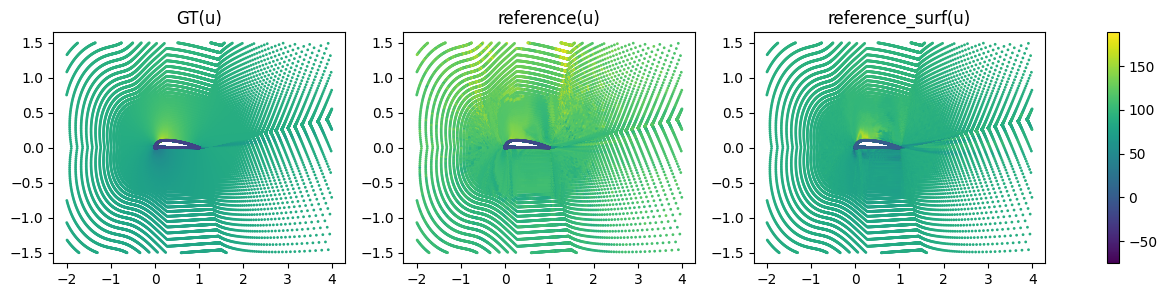

<Figure size 640x480 with 0 Axes>

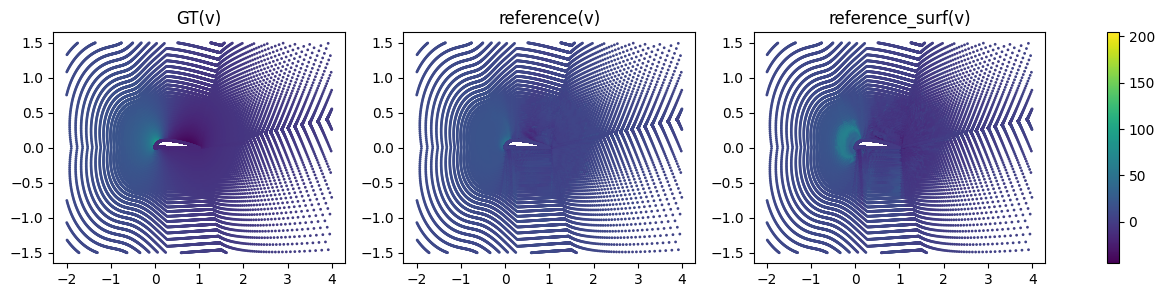

<Figure size 640x480 with 0 Axes>

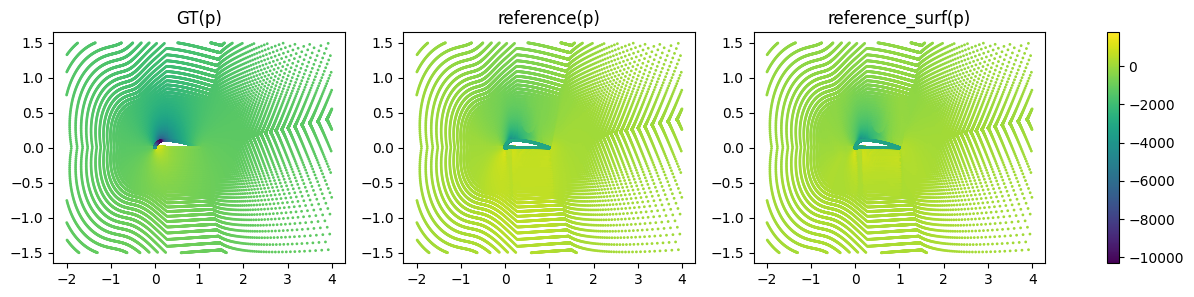

<Figure size 640x480 with 0 Axes>

In [151]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,3,figsize = (16,3))
i = 10
# U
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] ,s=1,cmap = 'viridis');  ax[0].set_title('GT(u)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests[i][:,0] ,s=1,cmap = 'viridis');  ax[1].set_title('reference(u)')
f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests1[i][:,0] ,s=1,cmap = 'viridis');  ax[2].set_title('reference_surf(u)')
fig.colorbar(f, ax=ax.ravel().tolist())
plt.show()
plt.clf()
# V
fig,ax = plt.subplots(1,3,figsize = (16,3))
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,1] ,s=1,cmap = 'viridis');  ax[0].set_title('GT(v)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests[i][:,1] ,s=1,cmap = 'viridis');  ax[1].set_title('reference(v)')
f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests1[i][:,1] ,s=1,cmap = 'viridis');  ax[2].set_title('reference_surf(v)')
fig.colorbar(f, ax=ax.ravel().tolist())
plt.show()
plt.clf()

fig,ax = plt.subplots(1,3,figsize = (16,3))
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,2] ,s=1,cmap = 'viridis');  ax[0].set_title('GT(p)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests[i][:,2] ,s=1,cmap = 'viridis');  ax[1].set_title('reference(p)')
f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_ests1[i][:,2] ,s=1,cmap = 'viridis');  ax[2].set_title('reference_surf(p)')
fig.colorbar(f, ax=ax.ravel().tolist())
plt.show()
plt.clf()

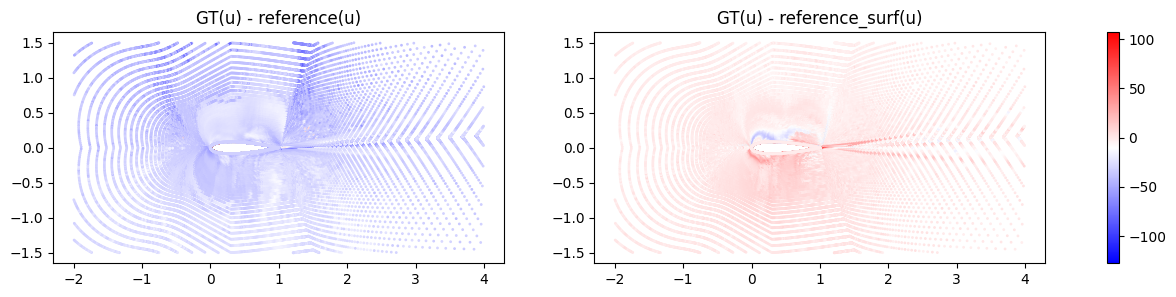

<Figure size 640x480 with 0 Axes>

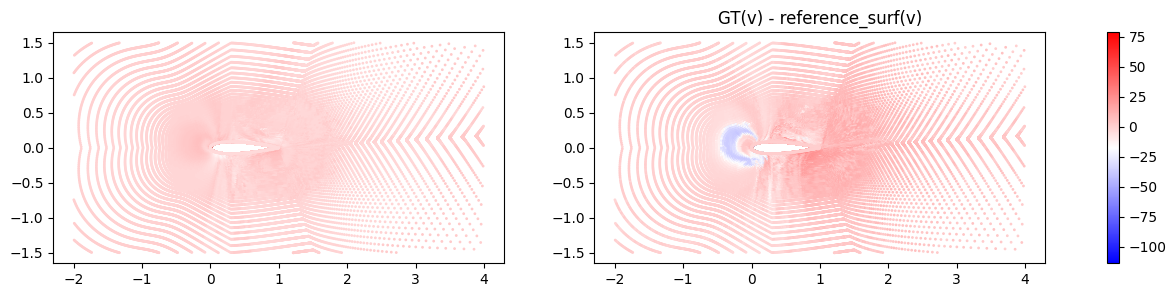

<Figure size 640x480 with 0 Axes>

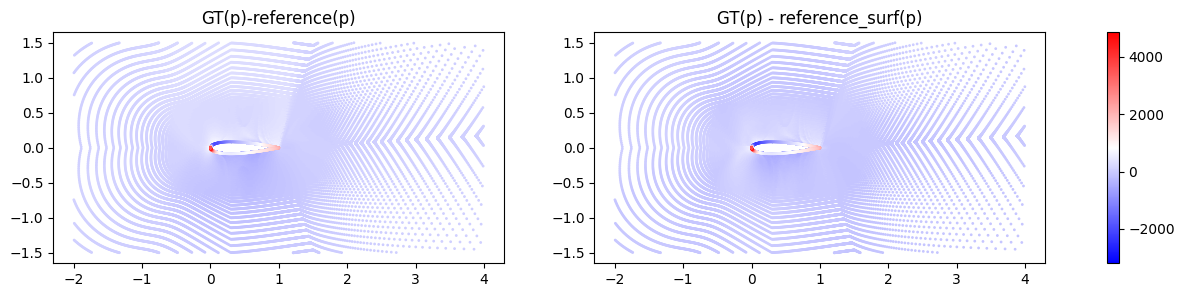

<Figure size 640x480 with 0 Axes>

In [153]:
from matplotlib import pyplot as plt
i = 20
fig,ax = plt.subplots(1,2,figsize = (16,3))
# plt.title('Residual')
# U residual
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] - test_ests[i][:,0] ,s=1,cmap = 'bwr');  \
            ax[0].set_title('GT(u) - reference(u)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] - test_ests1[i][:,0] ,s=1,cmap = 'bwr');  ax[1].set_title('GT(u) - reference_surf(u)')
# f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] - treference[i][:,0] ,s=1,cmap = 'bwr');  ax[2].set_title('GT(u) - reference_Model(u)')
fig.colorbar(f, ax=ax.ravel().tolist())
# fig.colorbar(f)
plt.show()
plt.clf()

fig,ax = plt.subplots(1,2,figsize = (16,3))
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,1] - test_ests[i][:,1] ,s=1,cmap = 'bwr');  ax[1].set_title('GT(v)-reference(v)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c=  test_set[i].y[:,1]-test_ests1[i][:,1] ,s=1,cmap = 'bwr');  ax[1].set_title('GT(v) - reference_surf(v)')
# f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] - treference[i][:,1] ,s=1,cmap = 'bwr');  ax[2].set_title('GT(v) - reference_Model(v)')
fig.colorbar(f, ax=ax.ravel().tolist())
# fig.colorbar(f)
plt.show()
plt.clf()
#P
fig,ax = plt.subplots(1,2,figsize = (16,3))
f = ax[0].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,2] - test_ests[i][:,2] ,s=1,cmap = 'bwr');  ax[0].set_title('GT(p)-reference(p)')
f = ax[1].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,2] - test_ests1[i][:,2] ,s=1,cmap = 'bwr');  ax[1].set_title('GT(p) - reference_surf(p)')
# f = ax[2].scatter(test_set[i].x[:,0],test_set[i].x[:,1],c= test_set[i].y[:,0] - treference[i][:,2] ,s=1,cmap = 'bwr');  ax[2].set_title('GT(p) - reference_Model(p)')
fig.colorbar(f, ax=ax.ravel().tolist())
# fig.colorbar(f)
plt.show()
plt.clf()

In [2]:
import torch
torch.load('train_ests1.pickle')[0]

tensor([[ 5.8670e+01, -3.6283e+00,  2.8284e+00,  3.1345e-09],
        [ 5.8664e+01, -3.6302e+00,  3.1747e+00,  3.1354e-09],
        [ 5.8658e+01, -3.6332e+00,  3.5412e+00,  3.1359e-09],
        ...,
        [ 0.0000e+00,  0.0000e+00,  1.5007e+03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.5007e+03,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.5007e+03,  0.0000e+00]],
       dtype=torch.float64)

In [3]:
torch.load('train_ests1_uvp.pickle')[0]

tensor([[ 3.6580e+01,  3.3789e+00, -1.3477e+00, -1.5313e+00],
        [ 3.3782e+01,  1.8585e+00, -1.0337e+00, -8.9600e-02],
        [ 3.6978e+01,  1.2985e+00, -6.7642e-01, -1.9128e+00],
        ...,
        [ 1.5564e-01, -5.7237e-03, -1.3100e+03, -1.9036e+00],
        [ 1.5564e-01, -5.7237e-03, -1.3100e+03, -1.9036e+00],
        [ 1.5564e-01, -5.7237e-03, -1.3100e+03, -1.9036e+00]],
       dtype=torch.float64)

In [7]:
# find MS-distance between two input airfoils

# less crude option 0: use some form of warping to match airfoil shapes more exactly

####

# crude options 1 and 2: use either x,y-pos or SDF,SAF to interpolate to find MSD

def getMSD(airfoilA, airfoilB, use_x=False):
    '''
    find MS-distance between input airfoil A and pool sample airfoil B fields
    airfoilB is interpolated on to airfoilA
    '''
    # airfoilA = airfoilA.to('cuda:0')
    # airfoilB=airfoilB.to('cuda:0')
    # print(airfoilA.x)
    # print(airfoilB.x)
    A_f,B_f = (airfoilA.x, airfoilB.x) if use_x else (airfoilA.y, airfoilB.y)

    #interpolate B onto the node positions of A using the x,y position coor.
    # B_inter_f = knn_interpolate(B_f, airfoilB.pos, airfoilA.pos, \
    #                             batch_x=airfoilB.batch, k=3)
    
    ####### OR, interpolate based on SDF and SAF rather than pos!!! #######
    A_sdaf = torch.stack([torch.norm(airfoilA.saf, dim=1), \
                          torch.atan2(airfoilA.saf[:,0],airfoilA.saf[:,1])],dim=1)
    B_sdaf = torch.stack([torch.norm(airfoilB.saf, dim=1), \
                          torch.atan2(airfoilB.saf[:,0],airfoilB.saf[:,1])],dim=1)
    B_inter_f = knn_interpolate(B_f, B_sdaf, A_sdaf, \
                                batch_x=airfoilB.batch, k=3)

    #find "MSE" between airfoils, representing distance
    MSD = ((A_f - B_inter_f)**2).mean()
    return MSD, B_inter_f

# based on MSD, find the most similar (but not equal) airfoil GT to use as estimate

def closestAirfoil(airfoils, pool, use_x=False, exclude_self=False):
    '''for every airfoil in (airfoils = Testset/training-set), find closest one in pool (pool=Training set). 
    Returns List of airfoils, list of MSD's .
    '''
    closest_fs = [] #closest = torch.zeros(len(airfoils))
    closest_ds = torch.zeros(len(airfoils))
    for A in tqdm(range(len(airfoils))): #airfoilA in airfoils:
        closest_dist = torch.inf

        for i in range(len(pool)): #airfoilB in pool:
            if exclude_self and A==i:
                closest_dist = closest_dist #no update if closest is self
            else:
                dist, B_f = getMSD(airfoils[A], pool[i], use_x=use_x)
                if (closest_dist > dist):
                    closest_dist = dist; closest_ind = i; closest_f = B_f

        #regardless of use_x's value, we want the closest interpolated y field
        if use_x==True:
            closest_f = getMSD(airfoils[A], pool[closest_ind], use_x=False)
        closest_fs.append(closest_f) #closest[A] = closest_ind
        closest_ds[A] = closest_dist
    return closest_fs, closest_ds

In [3]:
import json,os
from tqdm import tqdm
with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
    
train = manifest['scarce_train']
test = manifest['full_test']

train_set = [torch.load(os.path.join('nsresd/',airfoilA+'.pkl')) for airfoilA in tqdm(train)]
test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]

100%|█████████████████████████████████████████████████████████████████| 200/200 [02:04<00:00,  1.61it/s]


In [5]:
# option 0: Use potential flow instead of closest airfoil for estimate.

####

# crude option 1: Just use MSD of input x (rather than GT y) to get estimates
# consider: training with less-close/random airfoils as estimates also?

# >> load train and test sets first, then:
train_ests,_ = closestAirfoil(train_set, train_set, use_x=True, exclude_self=True)

test_ests,_ = closestAirfoil(test_set, train_set, use_x=True, exclude_self=False)


100%|███████████████████████████████████████████████████████████████| 200/200 [3:59:35<00:00, 71.88s/it]


In [16]:
torch.save([t[1] for t in train_ests],'train_ests.pickle')
torch.save([t[1] for t in test_ests],'test_ests.pickle')

In [19]:
torch.save([t for t in train_ests],'train_ests_all.pickle')
torch.save([t for t in test_ests],'test_ests_all.pickle')

In [6]:
train_ests[0]

tensor([[3.5948e+01, 7.2477e+00, 2.0888e+00, 7.5582e-10],
        [3.5956e+01, 7.1723e+00, 2.3743e+00, 6.7566e-10],
        [3.5963e+01, 7.0936e+00, 2.7199e+00, 5.7396e-10],
        ...,
        [0.0000e+00, 0.0000e+00, 4.2365e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.2365e+02, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 4.2365e+02, 0.0000e+00]], dtype=torch.float64)

In [3]:
import torch 
train_ests = torch.load('train_ests.pickle')
# [(i.shape,j.x.shape) for i,j in zip(train_ests[-20:],train_set[-20:])]

In [19]:
####
import json,os
# from tqdm.notebook import tqdm
from tqdm import tqdm

with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
    
train = manifest['scarce_train']
test = manifest['full_test']

# train_set = [torch.load(os.path.join('nsresd/',airfoilA+'.pkl')) for airfoilA in tqdm(train)]
# test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]

In [7]:
# del train_set
# del test_set

In [4]:
# less crude option 2: train NN to guess MSD-y from input parameters x-es
# input is: Aoa, Mach, NACA5 digits (if NACA4, replace one with "-1")???
# consider: training with less-close/random airfoils as estimates also??
def parameters_of(s):
    Uinf, alpha = float(s.split('_')[2]), float(s.split('_')[3])
    if len(s.split('_')[4:]) == 4:
        digit1,digit2,digit3,digit45 = [float(i) for i in s.split('_')[4:]]
        # assert digit3>=0
        characteristic = (Uinf,alpha, digit1,digit2,digit3,digit45)
        # characteristic = (Uinf,alpha, digit1,digit2,digit45)
    else:
        digit1,digit2,digit34 = [float(i) for i in s.split('_')[4:]]
        # characteristics.append((Uinf,alpha,digit1,digit2,-1,digit34))
        characteristic = (Uinf,alpha,digit1,digit2,-1,digit34)
    return characteristic
# >> create training set by pairing airfoils and finding their MSD-y
train_MSDset = []
for i,airfoilA in enumerate(tqdm(train)):
    dataA = torch.load(os.path.join('nsresd/',airfoilA+'.pkl'))
    for j,airfoilB in enumerate(train): #enumerate(tqdm(train)):
        inputA = torch.tensor(parameters_of(airfoilA)) #TODO
        inputB = torch.tensor(parameters_of(airfoilB)) #TODO
        input = torch.cat((inputA,inputB),dim=0)
        dataB = torch.load(os.path.join('nsresd/',airfoilB+'.pkl'))
        MSD_y = getMSD(dataA, dataB, use_x=False)
        # print(MSD_y)
        # _,MSD_y = getMSD(airfoilA, airfoilB, use_x=False)
        data = Data(x=input, y=torch.tensor(MSD_y[0]).to(torch.float32))
        train_MSDset.append(data)
    #     break
    # break
torch.save(train_MSDset,'train_MSDset.pickle')
# TODO: implement the model that trains with train_MSDset 
# - mlp
# -
# >> then train model to get airfoils' parameters as input and predict MSD >>>

  0%|                                                                                                       | 0/200 [00:00<?, ?it/s]/tmp/ipykernel_16548/1936408279.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = Data(x=input, y=torch.tensor(MSD_y[0]))
100%|███████████████████████████████████████████████████████████████████████████████████████████| 200/200 [5:04:11<00:00, 91.26s/it]


In [13]:
# !pip install ipywidgets

In [46]:
# for i in range(len(train_MSDset)):
#     train_MSDset[i].y = train_MSDset[i].y.to(torch.float32)
# torch.save(train_MSDset,'train_MSDset.pickle')

In [20]:
train_MSDset = torch.load('train_MSDset.pickle')

In [23]:
# train_MSDset[i].y.dtype
max_y = max([train_MSDset[i].y for i in range(len(train_MSDset))])
print(max_y)

tensor(1.)


In [22]:
for i in range(len(train_MSDset)):
    train_MSDset[i].y = train_MSDset[i].y/max_y

In [8]:
train_MSDset[1].y

tensor(0.0035)

In [24]:
from torch_geometric.data import DataListLoader
# from torch.nn import DataParallel
from torch_geometric.nn import DataParallel
from torch_geometric.nn.models import MLP
from tqdm import tqdm
## >>>
# READ (about optimisers and schedulers): https://pytorch.org/docs/stable/optim.html

##############################
###### estMSDy CLASS DEF #####
##############################
#estMSDy CLASS codes, using MLP.

class estMSDy(torch.nn.Module):
    def __init__(self, layers=[14,28,125,28,1], dropout=0.3):
        super(estMSDy, self).__init__()
        self.layers = MLP(layers,dropout=0.3)

    def forward(self, batch):
        # print(batch.x.shape)
        # batch = batch.unsqueeze(0)
        x = self.layers(batch.x.clone().unsqueeze(0))
        return x, batch.y


##############################
#### estMSDyfit CLASS DEF ####
##############################
#estMSDyfit CLASS: fit() func
class estMSDyfit:
    def __init__(self, layers=[14,28,125,28,1], dropout=0.3, device='cuda:0'):
        self.model = estMSDy(layers, dropout=dropout)#.to(device)

        if torch.cuda.device_count() > 1:
            self.model = DataParallel(self.model)
        self.model.to(device); 
        self.device=device; 
        self.mean,self.var = None,None
        self.tb = SummaryWriter() #tensorboard --logdir=runs

    def fit(self, dataset, max_epoch=100, bs=3, L1=10, lr=1e-4, weight_decay=1e-6, verbose=True):
        criterion = nn.MSELoss().to(self.device);
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)
        
        self.model.train() #force dropouts to occur.
        start=time.time(); #print(self.model);
        self.tb = SummaryWriter() #TensorBoard to show progress

        scaler = torch.cuda.amp.GradScaler() #ADDED: half pres
        for epoch in tqdm(range(max_epoch)):
            running_loss=0; num_batches=0
            # create minibatches
            #trainLoader = DataLoader(dataset, batch_size=bs, shuffle=True)
            trainLoader = DataListLoader(dataset, batch_size=bs, shuffle=True)
            Losslist = []
            for batch_list in trainLoader:
                #batch = batch.to(self.device)
                optimizer.zero_grad() #ADDED

                # do one step of stochastic gradient descent: U=U-lr(dL/dU)
                with torch.cuda.amp.autocast(): #ADDED: half pres
                    self.model.eval()
                    outputs, inputs = self.model(batch_list)
                    outputs = outputs.reshape(inputs.shape)
                    loss = criterion(outputs, inputs).mean()
                    if torch.isinf(loss).item() is True:
                        print("loss: ",loss.item()," outputs: ",outputs," inputs: ",inputs)
                    scaler.scale(loss).backward() #ADDED: half pres
                    nn.utils.clip_grad_norm_(self.model.parameters(), 5) #if nan loss!
                    scaler.step(optimizer) #ADDED: half pres
                    scaler.update() #ADDED: half pres

                    # add the loss of this batch to the running loss
                    # running_loss += loss.detach().item(); 
                    Losslist.append(loss.detach().item())
                    num_batches+=1
            # break
            # compute stats for the full training set
            scheduler.step() #anneal lr
            total_loss = torch.sum(torch.tensor(Losslist)/num_batches).item(); elapsed = time.time()-start
            self.tb.add_scalar("Loss/Epoch", total_loss, epoch) #TB plot loss
            # print(Losslist)
            if verbose & (epoch%5 == 0):
                #print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
                print('epoch=',epoch,'\t time=',elapsed,'\t loss=',total_loss)

        self.tb.close #Tensorboard close
        return self

In [83]:
# torch.isinf(torch.tensor([1, 2, float('nan')])).any().item() is False

True

Shallow Reference-finder model
----

In [ ]:
# >>> train the model

# trainedMSD = estMSDyfit(device = 'cuda:0', layers=[14,28,125,28,1], dropout=0.3)
trainedMSD = estMSDyfit(device = 'cuda:0', layers=[12,24,120,24,1], dropout=0.3)
trainMSD = trainedMSD.fit(train_MSDset,max_epoch = 200)
torch.save(trainedMSD.model.module,'estMSDy_model')

  0%|                                                                                                       | 0/200 [00:00<?, ?it/s]/home/jessica/anaconda3/envs/airfrans_env/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)
  0%|▍                                                                                          | 1/200 [03:49<12:39:55, 229.13s/it]

epoch= 0 	 time= 229.1343469619751 	 loss= 0.006092473864555359


  3%|██▋                                                                                        | 6/200 [22:19<12:00:09, 222.73s/it]

epoch= 5 	 time= 1339.2698955535889 	 loss= 0.005075478460639715


  6%|████▉                                                                                     | 11/200 [40:49<11:38:34, 221.77s/it]

epoch= 10 	 time= 2449.1500749588013 	 loss= 0.004957763943821192


  8%|███████▏                                                                                  | 16/200 [59:16<11:18:21, 221.20s/it]

epoch= 15 	 time= 3556.2486095428467 	 loss= 0.004981267731636763


 10%|█████████▏                                                                              | 21/200 [1:17:39<10:58:57, 220.88s/it]

epoch= 20 	 time= 4659.7702379226685 	 loss= 0.004962268751114607


 13%|███████████▍                                                                            | 26/200 [1:36:16<10:47:14, 223.19s/it]

epoch= 25 	 time= 5776.844442129135 	 loss= 0.0049577378667891026


 16%|█████████████▋                                                                          | 31/200 [1:55:34<10:54:02, 232.21s/it]

epoch= 30 	 time= 6934.504254579544 	 loss= 0.004960033111274242


 18%|███████████████▊                                                                        | 36/200 [2:15:17<10:44:29, 235.79s/it]

epoch= 35 	 time= 8117.12274479866 	 loss= 0.004950367379933596


 20%|██████████████████                                                                      | 41/200 [2:35:00<10:26:48, 236.53s/it]

epoch= 40 	 time= 9300.483174324036 	 loss= 0.004945055115967989


 23%|████████████████████▏                                                                   | 46/200 [2:54:42<10:06:53, 236.45s/it]

epoch= 45 	 time= 10482.706132173538 	 loss= 0.004946892149746418


 26%|██████████████████████▋                                                                  | 51/200 [3:14:27<9:48:22, 236.93s/it]

epoch= 50 	 time= 11667.102919101715 	 loss= 0.004967927932739258


 28%|████████████████████████▉                                                                | 56/200 [3:34:11<9:28:32, 236.89s/it]

epoch= 55 	 time= 12851.17606496811 	 loss= 0.0049606431275606155


 30%|███████████████████████████▏                                                             | 61/200 [3:53:55<9:08:48, 236.89s/it]

epoch= 60 	 time= 14035.734531879425 	 loss= 0.0049496004357934


 33%|█████████████████████████████▎                                                           | 66/200 [4:13:34<8:48:18, 236.56s/it]

epoch= 65 	 time= 15214.943178653717 	 loss= 0.004965906962752342


 36%|███████████████████████████████▌                                                         | 71/200 [4:33:22<8:30:43, 237.55s/it]

epoch= 70 	 time= 16402.288913488388 	 loss= 0.004959818907082081


 38%|█████████████████████████████████▊                                                       | 76/200 [4:53:07<8:09:50, 237.02s/it]

epoch= 75 	 time= 17587.40754175186 	 loss= 0.004954705014824867


 40%|████████████████████████████████████                                                     | 81/200 [5:12:49<7:48:53, 236.42s/it]

epoch= 80 	 time= 18769.993580818176 	 loss= 0.004955574870109558


 43%|██████████████████████████████████████▎                                                  | 86/200 [5:32:28<7:28:05, 235.84s/it]

epoch= 85 	 time= 19948.558598279953 	 loss= 0.004949215799570084


 46%|████████████████████████████████████████▍                                                | 91/200 [5:52:05<7:07:44, 235.46s/it]

epoch= 90 	 time= 21125.835968017578 	 loss= 0.004799177870154381


 48%|██████████████████████████████████████████▋                                              | 96/200 [6:11:41<6:47:19, 234.99s/it]

epoch= 95 	 time= 22301.184965610504 	 loss= 0.004505337215960026


 50%|████████████████████████████████████████████▍                                           | 101/200 [6:31:18<6:28:24, 235.40s/it]

epoch= 100 	 time= 23478.898816347122 	 loss= 0.004433964379131794


 53%|██████████████████████████████████████████████▋                                         | 106/200 [6:50:56<6:09:13, 235.68s/it]

epoch= 105 	 time= 24656.64513540268 	 loss= 0.004404970910400152


 56%|████████████████████████████████████████████████▊                                       | 111/200 [7:10:36<5:49:48, 235.82s/it]

epoch= 110 	 time= 25836.715764284134 	 loss= 0.004426330793648958


 58%|███████████████████████████████████████████████████                                     | 116/200 [7:30:13<5:29:47, 235.57s/it]

epoch= 115 	 time= 27013.144926071167 	 loss= 0.004417039453983307


 60%|█████████████████████████████████████████████████████▏                                  | 121/200 [7:49:53<5:10:45, 236.02s/it]

epoch= 120 	 time= 28193.452633857727 	 loss= 0.004421261139214039


 63%|███████████████████████████████████████████████████████▍                                | 126/200 [8:09:30<4:50:52, 235.84s/it]

epoch= 125 	 time= 29370.742928266525 	 loss= 0.004423210397362709


 66%|█████████████████████████████████████████████████████████▋                              | 131/200 [8:29:05<4:30:38, 235.34s/it]

epoch= 130 	 time= 30545.58137536049 	 loss= 0.004414243157953024


 68%|███████████████████████████████████████████████████████████▊                            | 136/200 [8:48:43<4:11:13, 235.53s/it]

epoch= 135 	 time= 31723.944105625153 	 loss= 0.004417478106915951


 70%|██████████████████████████████████████████████████████████████                          | 141/200 [9:08:19<3:51:03, 234.97s/it]

epoch= 140 	 time= 32899.24282979965 	 loss= 0.004407471977174282


Deeper reference-finder model
---

In [26]:
trainedMSD = estMSDyfit(device = 'cuda:0', layers=[12,48,128,48,12,1], dropout=0.3)
trainMSD = trainedMSD.fit(train_MSDset,max_epoch = 200)
torch.save(trainedMSD.model.module,'estMSDy_model_deep')

  0%|▎                                                                        | 1/200 [10:56<36:18:51, 656.94s/it]

epoch= 0 	 time= 656.9446823596954 	 loss= 0.006446370854973793


  3%|██▏                                                                    | 6/200 [1:04:11<34:34:51, 641.71s/it]

epoch= 5 	 time= 3851.9360098838806 	 loss= 0.005950435996055603


  6%|███▊                                                                  | 11/200 [1:57:25<33:29:54, 638.07s/it]

epoch= 10 	 time= 7045.976255893707 	 loss= 0.005950686056166887


  8%|█████▌                                                                | 16/200 [2:51:03<32:50:40, 642.61s/it]

epoch= 15 	 time= 10263.317639350891 	 loss= 0.005941013805568218


 10%|███████▎                                                              | 21/200 [3:44:14<31:49:51, 640.18s/it]

epoch= 20 	 time= 13454.969319343567 	 loss= 0.005942708812654018


 13%|█████████                                                             | 26/200 [4:37:23<30:53:51, 639.26s/it]

epoch= 25 	 time= 16643.380044937134 	 loss= 0.005944225937128067


 16%|██████████▊                                                           | 31/200 [5:30:41<30:01:33, 639.61s/it]

epoch= 30 	 time= 19841.289984941483 	 loss= 0.005951302591711283


 18%|████████████▌                                                         | 36/200 [6:24:01<29:15:22, 642.21s/it]

epoch= 35 	 time= 23041.875275611877 	 loss= 0.005946023389697075


 20%|██████████████▎                                                       | 41/200 [7:16:57<28:06:07, 636.28s/it]

epoch= 40 	 time= 26217.043100118637 	 loss= 0.005947296507656574


 23%|████████████████                                                      | 46/200 [8:10:00<27:14:41, 636.89s/it]

epoch= 45 	 time= 29400.099104881287 	 loss= 0.005946374498307705


 26%|█████████████████▊                                                    | 51/200 [9:02:52<26:17:01, 635.04s/it]

epoch= 50 	 time= 32572.382694005966 	 loss= 0.00594593770802021


 28%|███████████████████▌                                                  | 56/200 [9:55:50<25:24:12, 635.09s/it]

epoch= 55 	 time= 35750.36529779434 	 loss= 0.005943171679973602


 30%|█████████████████████                                                | 61/200 [10:48:48<24:32:30, 635.61s/it]

epoch= 60 	 time= 38928.90814828873 	 loss= 0.005942448973655701


 33%|██████████████████████▊                                              | 66/200 [11:41:49<23:41:53, 636.67s/it]

epoch= 65 	 time= 42109.82750368118 	 loss= 0.005943913944065571


 36%|████████████████████████▍                                            | 71/200 [12:34:37<22:43:13, 634.06s/it]

epoch= 70 	 time= 45277.71718096733 	 loss= 0.0059485905803740025


 38%|██████████████████████████▏                                          | 76/200 [13:27:26<21:49:43, 633.73s/it]

epoch= 75 	 time= 48446.186108350754 	 loss= 0.005946031305938959


 40%|███████████████████████████▉                                         | 81/200 [14:20:24<21:02:04, 636.34s/it]

epoch= 80 	 time= 51624.125614881516 	 loss= 0.005949808284640312


 43%|█████████████████████████████▋                                       | 86/200 [15:13:22<20:10:28, 637.09s/it]

epoch= 85 	 time= 54802.91799879074 	 loss= 0.005948171019554138


 46%|███████████████████████████████▍                                     | 91/200 [16:06:33<19:17:07, 636.95s/it]

epoch= 90 	 time= 57993.221841573715 	 loss= 0.00593924056738615


 48%|█████████████████████████████████                                    | 96/200 [16:59:40<18:24:27, 637.19s/it]

epoch= 95 	 time= 61180.4852142334 	 loss= 0.005940800532698631


 50%|██████████████████████████████████▎                                 | 101/200 [17:52:49<17:33:50, 638.69s/it]

epoch= 100 	 time= 64369.302867889404 	 loss= 0.00594315305352211


 53%|████████████████████████████████████                                | 106/200 [18:46:18<16:44:09, 640.95s/it]

epoch= 105 	 time= 67578.0437180996 	 loss= 0.005941295996308327


 56%|█████████████████████████████████████▋                              | 111/200 [19:39:49<15:52:33, 642.18s/it]

epoch= 110 	 time= 70789.11749577522 	 loss= 0.00594498123973608


 58%|███████████████████████████████████████▍                            | 116/200 [20:34:07<15:07:46, 648.41s/it]

epoch= 115 	 time= 74047.01733136177 	 loss= 0.00594883318990469


 60%|█████████████████████████████████████████▏                          | 121/200 [21:28:02<14:10:17, 645.79s/it]

epoch= 120 	 time= 77282.91407132149 	 loss= 0.0059475647285580635


 63%|██████████████████████████████████████████▊                         | 126/200 [22:20:56<13:02:21, 634.34s/it]

epoch= 125 	 time= 80456.29855680466 	 loss= 0.005945522338151932


 66%|████████████████████████████████████████████▌                       | 131/200 [23:13:33<12:06:39, 631.87s/it]

epoch= 130 	 time= 83613.50070142746 	 loss= 0.005944833625108004


 68%|██████████████████████████████████████████████▏                     | 136/200 [24:05:57<11:11:18, 629.35s/it]

epoch= 135 	 time= 86757.86199426651 	 loss= 0.005944530479609966


 70%|███████████████████████████████████████████████▉                    | 141/200 [24:58:34<10:21:05, 631.62s/it]

epoch= 140 	 time= 89914.72200798988 	 loss= 0.005945882294327021


 73%|██████████████████████████████████████████████████▎                  | 146/200 [25:50:57<9:26:09, 629.06s/it]

epoch= 145 	 time= 93057.17376565933 	 loss= 0.005949768237769604


 76%|████████████████████████████████████████████████████                 | 151/200 [26:43:24<8:33:55, 629.30s/it]

epoch= 150 	 time= 96204.93460083008 	 loss= 0.005941764451563358


 78%|█████████████████████████████████████████████████████▊               | 156/200 [27:36:02<7:42:23, 630.53s/it]

epoch= 155 	 time= 99362.37194800377 	 loss= 0.005944320932030678


 80%|███████████████████████████████████████████████████████▌             | 161/200 [28:22:22<5:54:52, 545.95s/it]

epoch= 160 	 time= 102142.86895799637 	 loss= 0.005944370292127132


 83%|█████████████████████████████████████████████████████████▎           | 166/200 [29:02:39<4:40:33, 495.10s/it]

epoch= 165 	 time= 104559.501257658 	 loss= 0.005941732320934534


 86%|██████████████████████████████████████████████████████████▉          | 171/200 [29:42:37<3:52:43, 481.51s/it]

epoch= 170 	 time= 106957.14150857925 	 loss= 0.005942190997302532


 88%|████████████████████████████████████████████████████████████▋        | 176/200 [30:23:01<3:13:45, 484.38s/it]

epoch= 175 	 time= 109381.38095164299 	 loss= 0.005943384021520615


 90%|██████████████████████████████████████████████████████████████▍      | 181/200 [31:03:26<2:33:43, 485.43s/it]

epoch= 180 	 time= 111806.78783607483 	 loss= 0.0059486618265509605


 93%|████████████████████████████████████████████████████████████████▏    | 186/200 [31:43:54<1:53:07, 484.81s/it]

epoch= 185 	 time= 114234.77743816376 	 loss= 0.005946448538452387


 96%|█████████████████████████████████████████████████████████████████▉   | 191/200 [32:24:02<1:12:28, 483.15s/it]

epoch= 190 	 time= 116642.09352183342 	 loss= 0.005946182645857334


 98%|█████████████████████████████████████████████████████████████████████▌ | 196/200 [33:04:05<32:01, 480.41s/it]

epoch= 195 	 time= 119045.11745977402 	 loss= 0.0059479884803295135


100%|███████████████████████████████████████████████████████████████████████| 200/200 [33:36:18<00:00, 604.89s/it]


In [29]:
trainedMSD = estMSDyfit(device = 'cuda:0', layers=[12,24,48,24,12,1], dropout=0.3)
trainMSD = trainedMSD.fit(train_MSDset,max_epoch = 100)
torch.save(trainedMSD.model.module,'estMSDy_model_deep1')

  1%|▊                                                                                   | 1/100 [04:26<7:19:02, 266.08s/it]

epoch= 0 	 time= 266.0825958251953 	 loss= 0.005496194586157799


  6%|█████                                                                               | 6/100 [27:04<7:05:01, 271.30s/it]

epoch= 5 	 time= 1624.3971858024597 	 loss= 0.005670782644301653


 11%|█████████▏                                                                         | 11/100 [49:34<6:41:29, 270.67s/it]

epoch= 10 	 time= 2974.9334621429443 	 loss= 0.005577763542532921


 16%|████████████▉                                                                    | 16/100 [1:12:04<6:18:14, 270.18s/it]

epoch= 15 	 time= 4324.720349788666 	 loss= 0.005577223375439644


 21%|█████████████████                                                                | 21/100 [1:34:37<5:55:25, 269.95s/it]

epoch= 20 	 time= 5677.342479944229 	 loss= 0.005538742057979107


 26%|█████████████████████                                                            | 26/100 [1:57:08<5:33:11, 270.15s/it]

epoch= 25 	 time= 7028.444688081741 	 loss= 0.00554431090131402


 31%|█████████████████████████                                                        | 31/100 [2:19:33<5:09:57, 269.53s/it]

epoch= 30 	 time= 8373.428665161133 	 loss= 0.005568743217736483


 36%|█████████████████████████████▏                                                   | 36/100 [2:42:11<4:49:13, 271.14s/it]

epoch= 35 	 time= 9731.108633518219 	 loss= 0.005549923982471228


 41%|█████████████████████████████████▏                                               | 41/100 [3:04:35<4:25:26, 269.94s/it]

epoch= 40 	 time= 11075.19253373146 	 loss= 0.005550253205001354


 46%|█████████████████████████████████████▎                                           | 46/100 [3:27:05<4:03:03, 270.07s/it]

epoch= 45 	 time= 12425.310703754425 	 loss= 0.005547069478780031


 51%|█████████████████████████████████████████▎                                       | 51/100 [3:49:26<3:39:00, 268.18s/it]

epoch= 50 	 time= 13766.794824361801 	 loss= 0.005545277148485184


 56%|█████████████████████████████████████████████▎                                   | 56/100 [4:12:03<3:18:34, 270.79s/it]

epoch= 55 	 time= 15123.396596431732 	 loss= 0.005546119529753923


 61%|█████████████████████████████████████████████████▍                               | 61/100 [4:34:36<2:55:53, 270.60s/it]

epoch= 60 	 time= 16476.021866559982 	 loss= 0.005543475039303303


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [4:57:02<2:32:28, 269.07s/it]

epoch= 65 	 time= 17822.12475681305 	 loss= 0.005538478028029203


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [5:19:21<2:09:45, 268.46s/it]

epoch= 70 	 time= 19161.81566619873 	 loss= 0.005541544873267412


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [5:41:53<1:48:02, 270.12s/it]

epoch= 75 	 time= 20513.91240286827 	 loss= 0.00555271515622735


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [6:04:34<1:26:03, 271.78s/it]

epoch= 80 	 time= 21874.115638017654 	 loss= 0.005541388411074877


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [6:27:01<1:02:55, 269.71s/it]

epoch= 85 	 time= 23221.44041633606 	 loss= 0.005551212467253208


 91%|███████████████████████████████████████████████████████████████████████████▌       | 91/100 [6:49:37<40:39, 271.10s/it]

epoch= 90 	 time= 24577.69242501259 	 loss= 0.005541379097849131


 96%|███████████████████████████████████████████████████████████████████████████████▋   | 96/100 [7:12:03<18:01, 270.30s/it]

epoch= 95 	 time= 25923.145846366882 	 loss= 0.005561289377510548


100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [7:30:05<00:00, 270.05s/it]


In [28]:
torch.cuda.empty_cache()

In [32]:
# torch.save(trainedMSD.model.module,'estMSDy_model')
# trainedMSD.model.module

In [16]:
# >>> find predicted closest airfoils using the trained NN

trained_model = torch.load('estMSDy_model')
def parameters_of(s):
    Uinf, alpha = float(s.split('_')[2]), float(s.split('_')[3])
    if len(s.split('_')[4:]) == 4:
        digit1,digit2,digit3,digit45 = [float(i) for i in s.split('_')[4:]]
        # assert digit3>=0
        characteristic = (Uinf,alpha, digit1,digit2,digit3,digit45)
        # characteristic = (Uinf,alpha, digit1,digit2,digit45)
    else:
        digit1,digit2,digit34 = [float(i) for i in s.split('_')[4:]]
        # characteristics.append((Uinf,alpha,digit1,digit2,-1,digit34))
        characteristic = (Uinf,alpha,digit1,digit2,-1,digit34)
    return characteristic

@torch.no_grad()
def closestAirfoil_est(airfoils, pool, exclude_self=True, device = 'cuda:0'):
    closest_fs = []
    for A in tqdm(range(len(airfoils))):
        closest_dist = torch.inf
        dataA = torch.load(os.path.join('nsresd/',airfoils[A]+'.pkl'))
        for i in range(len(pool)):
            if exclude_self and A==i:
                closest_dist = closest_dist #no update if closest is self
            else:
                inputA = torch.tensor(parameters_of(airfoils[A])) 
                inputB = torch.tensor(parameters_of(pool[i]))
                # print(inputA,inputB)
                input = torch.cat((inputA,inputB),dim=0).to(device)
                input_d = Data(x = input)
                dist,_ = trained_model(input_d)
                # print(dist)
                if (closest_dist > dist):
                    closest_dist = dist; closest_B = inputB; dataB = torch.load(os.path.join('nsresd/',pool[i]+'.pkl'))
        
        # closest_f,_ = getMSD(airfoils[A], closest_B, use_x=False)
        closest_dist, closest_f = getMSD(dataA, dataB, use_x=False)
        # print(airfoils[A],closest_f)
        # print(closest_f.shape)
        closest_fs.append(closest_f)
    return closest_fs


# consider: training with less-close/random airfoils as estimates also??
train_ests = closestAirfoil_est(train, train, exclude_self=True)
test_ests = closestAirfoil_est(test, train, exclude_self=False)

100%|███████████████████████████████████████████████████████████████████████████| 200/200 [02:12<00:00,  1.51it/s]


In [17]:
torch.save(train_ests,'train_ests1.pickle')
torch.save(test_ests,'test_ests1.pickle')

In [15]:
train_ests

[tensor([[ 3.5842e+01,  6.0784e+00,  9.9927e+00,  3.2384e-09],
         [ 3.5832e+01,  6.0148e+00,  1.0728e+01,  3.2351e-09],
         [ 3.5821e+01,  5.9490e+00,  1.1527e+01,  3.2314e-09],
         ...,
         [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -1.1541e+03,  0.0000e+00]],
        dtype=torch.float64)]

``Add estimate attribute to data``

In [ ]:
for i,data in enumerate(train_set):
    data.estimate = train_ests[i]
for i,data in enumerate(test_set):
    data.estimate = test_ests[i]
# TODO: save

`interpolate based on position`

In [1]:
import torch
from torch_geometric.nn.unpool import knn_interpolate

from torch_geometric.data import Data

from torch_geometric.nn import MLP
from torch_geometric.nn.models import MLP
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn as nn
import time

# find MS-distance between two input airfoils

# less crude option 0: use some form of warping to match airfoil shapes more exactly

####

# crude options 1 and 2: use either x,y-pos or SDF,SAF to interpolate to find MSD

def getMSD(airfoilA, airfoilB, use_x=False):
    '''
    find MS-distance between input airfoil A and pool sample airfoil B fields
    airfoilB is interpolated on to airfoilA
    '''
    # airfoilA = airfoilA.to('cuda:0')
    # airfoilB=airfoilB.to('cuda:0')
    # print(airfoilA.x)
    # print(airfoilB.x)
    A_f,B_f = (airfoilA.x, airfoilB.x) if use_x else (airfoilA.y, airfoilB.y)

    #interpolate B onto the node positions of A using the x,y position coor.
    B_inter_f = knn_interpolate(B_f, airfoilB.x[:,:2], airfoilA.x[:,:2], \
                                batch_x=airfoilB.batch, k=3)
    
    ####### OR, interpolate based on SDF and SAF rather than pos!!! #######
    # A_sdaf = torch.stack([torch.norm(airfoilA.saf, dim=1), \
    #                       torch.atan2(airfoilA.saf[:,0],airfoilA.saf[:,1])],dim=1)
    # B_sdaf = torch.stack([torch.norm(airfoilB.saf, dim=1), \
    #                       torch.atan2(airfoilB.saf[:,0],airfoilB.saf[:,1])],dim=1)
    # B_inter_f = knn_interpolate(B_f, B_sdaf, A_sdaf, \
    #                             batch_x=airfoilB.batch, k=3)

    #find "MSE" between airfoils, representing distance
    MSD = ((A_f - B_inter_f)**2).mean()
    return MSD, B_inter_f

# based on MSD, find the most similar (but not equal) airfoil GT to use as estimate

def closestAirfoil(airfoils, pool, use_x=False, exclude_self=False):
    '''for every airfoil in (airfoils = Testset/training-set), find closest one in pool (pool=Training set). 
    Returns List of airfoils, list of MSD's .
    '''
    closest_fs = [] #closest = torch.zeros(len(airfoils))
    closest_ds = torch.zeros(len(airfoils))
    for A in tqdm(range(len(airfoils))): #airfoilA in airfoils:
        closest_dist = torch.inf

        for i in range(len(pool)): #airfoilB in pool:
            if exclude_self and A==i:
                closest_dist = closest_dist #no update if closest is self
            else:
                dist, B_f = getMSD(airfoils[A], pool[i], use_x=use_x)
                if (closest_dist > dist):
                    closest_dist = dist; closest_ind = i; closest_f = B_f

        #regardless of use_x's value, we want the closest interpolated y field
        if use_x==True:
            closest_f = getMSD(airfoils[A], pool[closest_ind], use_x=False)
        closest_fs.append(closest_f) #closest[A] = closest_ind
        closest_ds[A] = closest_dist
    return closest_fs, closest_ds
import json,os
from tqdm import tqdm
with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
    
train = manifest['scarce_train']
test = manifest['full_test']

train_set = [torch.load(os.path.join('nsresd/',airfoilA+'.pkl')) for airfoilA in tqdm(train)]
test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]
test_ests,_ = closestAirfoil(test_set, train_set, use_x=True, exclude_self=False)
torch.save([t[1] for t in test_ests],'test_ests_pos.pickle')

/home/jessica/anaconda3/envs/airfrans_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [4:02:21<00:00, 72.71s/it]


LR reference
---

In [15]:
import torch
import json,os
from tqdm import tqdm
from torch_geometric.nn.unpool import knn_interpolate
with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
    
train = manifest['scarce_train']
test = manifest['full_test']
train_set = [torch.load(os.path.join('nsresd/',airfoilA+'.pkl')) for airfoilA in tqdm(train)]
test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]
# path = '/ntuzfs/jessica/cfd-gcn_geom/cccoarse_ns/'
path = '/home/jessica/Downloads/submission/cfd-gcn_geom/cccoarse_ns/'

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.23it/s]


In [27]:
test_set = [torch.load(os.path.join('nsresd/',airfoilB+'.pkl')) for airfoilB in tqdm(test)]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:22<00:00,  1.41it/s]


In [28]:
import torch_geometric
from matplotlib import pyplot as plt
def upsample(y, coarse_nodes, fine):
    fine_nodes = fine.x[:, :2].to(dtype=torch.float32)
    y = knn_interpolate(y.cpu(), coarse_nodes[:, :2].cpu(), fine_nodes.cpu(),
                         k=3).to(y.device)
    return y
    
def get_coarse_data(f):
    coarse_file = os.path.join(path,f+'.pkl')
    coarse_data = torch.load(coarse_file)
    return coarse_data
train_ests = []
for i,f in tqdm(enumerate(train)):
    coarse_data = get_coarse_data(f)
    fine_data = train_set[i]
    fine_x = fine_data.x
    # print(coarse_data)
    coarse_y = coarse_data.y.to(dtype=torch.float32)
    coarse_x = coarse_data.x.to(dtype=torch.float32)
    # coarse_data = torch_geometric.data.Batch(coarse_data)
    # coarse_batch = coarse_data.batch
    upsampled_coarse = upsample(coarse_y, coarse_x, fine_data).to(fine_x.device)
    train_ests.append(upsampled_coarse)
    # print(upsampled_coarse.shape)
    # print(fine_x.shape,' ',fine_data.y.shape)
    # res_u = upsampled_coarse[:,0]-fine_data.y[:,0]
    # res_v = upsampled_coarse[:,1]-fine_data.y[:,1]
    # res_p = upsampled_coarse[:,2]-fine_data.y[:,2]
    # res_nut = upsampled_coarse[:,3]-fine_data.y[:,3]
    # fig,ax = plt.subplots(1,3,figsize = (16,3))
    # plt.scatter(fine_data.x[:,0],fine_data.x[:,1],c= res_u ,s=1,cmap = 'bwr');  plt.colorbar(); plt.show()
    # plt.clf()
    # plt.scatter(fine_data.x[:,0],fine_data.x[:,1],c= res_v ,s=1,cmap = 'bwr');  plt.colorbar(); plt.show()
    # plt.clf()
    # plt.scatter(fine_data.x[:,0],fine_data.x[:,1],c= res_p ,s=1,cmap = 'bwr');  plt.colorbar(); plt.show()
    # plt.clf()
    # plt.scatter(fine_data.x[:,0],fine_data.x[:,1],c= res_nut ,s=1,cmap = 'bwr');  plt.colorbar(); plt.show()
    # plt.clf()
test_ests = []
for i,f in tqdm(enumerate(test)):
    coarse_data = get_coarse_data(f)
    fine_data = test_set[i]
    fine_x = fine_data.x
    # print(coarse_data)
    coarse_y = coarse_data.y.to(dtype=torch.float32)
    coarse_x = coarse_data.x.to(dtype=torch.float32)
    upsampled_coarse = upsample(coarse_y, coarse_x, fine_data).to(fine_x.device)
    test_ests.append(upsampled_coarse)

200it [00:24,  8.10it/s]
200it [00:30,  6.56it/s]


In [29]:
torch.save(train_ests,'train_ests_ucm.pickle')
torch.save(test_ests,'test_ests_ucm.pickle')

In [38]:
train_ests_ucm = torch.load('train_ests_ucm.pickle')
train_ests_uvp = torch.load('train_ests1_uvp.pickle')
train_ests_pos = torch.load('train_ests_pos.pickle')
train_ests_saf = torch.load('train_ests.pickle')
train_ests_sincos = torch.load('train_ests1_sincos.pickle')

In [40]:
gt = [data.y for data in train_set]

In [45]:
import torch.nn as nn
criterion = nn.MSELoss(reduction = 'none')
loss_ucm = torch.tensor([criterion(g, est).mean(dim = 0).mean() for est,g in zip(train_ests_ucm,gt)]).mean()
loss_uvp = torch.tensor([criterion(g, est).mean(dim = 0).mean() for est,g in zip(train_ests_uvp,gt)]).mean()
loss_pos = torch.tensor([criterion(g, est).mean(dim = 0).mean() for est,g in zip(train_ests_pos,gt)]).mean()
loss_saf = torch.tensor([criterion(g, est).mean(dim = 0).mean() for est,g in zip(train_ests_saf,gt)]).mean()
loss_sincos = torch.tensor([criterion(g, est).mean(dim = 0).mean() for est,g in zip(train_ests_sincos,gt)]).mean()

In [46]:
print(loss_ucm)
print(loss_uvp)
print(loss_pos)
print(loss_saf)
print(loss_sincos)

tensor(1585003.9062, dtype=torch.float64)
tensor(563486.9545, dtype=torch.float64)
tensor(846800.3767, dtype=torch.float64)
tensor(1156760.7071, dtype=torch.float64)
tensor(1401847.4320, dtype=torch.float64)


In [58]:
[criterion(g, est).mean(dim = 0) for est,g in zip(train_ests_uvp,gt)][:20]

[tensor([6.2369e+01, 1.4499e+02, 7.3404e+05, 4.6410e+01], dtype=torch.float64),
 tensor([1.1752e+02, 1.0152e+02, 7.0983e+05, 1.7495e+01], dtype=torch.float64),
 tensor([1.1765e+02, 1.2328e+02, 3.8270e+05, 2.9872e+01], dtype=torch.float64),
 tensor([2.5319e+02, 2.9495e+02, 2.0959e+06, 5.4496e+01], dtype=torch.float64),
 tensor([1.9720e+02, 1.3674e+02, 4.6896e+06, 3.6608e+01], dtype=torch.float64),
 tensor([8.9257e+01, 8.7074e+01, 1.3481e+06, 8.3633e+00], dtype=torch.float64),
 tensor([8.1462e+01, 1.2009e+02, 3.6639e+05, 4.7400e+01], dtype=torch.float64),
 tensor([1.3133e+02, 2.5855e+02, 1.0456e+06, 3.3567e+01], dtype=torch.float64),
 tensor([8.3971e+01, 1.4433e+02, 6.3942e+05, 1.4397e+01], dtype=torch.float64),
 tensor([2.4518e+02, 3.2669e+02, 1.6995e+06, 5.4829e+01], dtype=torch.float64),
 tensor([8.8727e+01, 9.6762e+01, 1.4483e+05, 2.3921e+01], dtype=torch.float64),
 tensor([6.8563e+01, 1.6408e+02, 1.1687e+06, 1.9718e+01], dtype=torch.float64),
 tensor([3.4995e+02, 5.4667e+02, 3.5017e

In [53]:
[criterion(g, est).mean(dim = 0) for est,g in zip(train_ests_uvp,gt)][:20]

[tensor([6.2369e+01, 1.4499e+02, 7.3404e+05, 4.6410e+01], dtype=torch.float64),
 tensor([1.1752e+02, 1.0152e+02, 7.0983e+05, 1.7495e+01], dtype=torch.float64),
 tensor([1.1765e+02, 1.2328e+02, 3.8270e+05, 2.9872e+01], dtype=torch.float64),
 tensor([2.5319e+02, 2.9495e+02, 2.0959e+06, 5.4496e+01], dtype=torch.float64),
 tensor([1.9720e+02, 1.3674e+02, 4.6896e+06, 3.6608e+01], dtype=torch.float64),
 tensor([8.9257e+01, 8.7074e+01, 1.3481e+06, 8.3633e+00], dtype=torch.float64),
 tensor([8.1462e+01, 1.2009e+02, 3.6639e+05, 4.7400e+01], dtype=torch.float64),
 tensor([1.3133e+02, 2.5855e+02, 1.0456e+06, 3.3567e+01], dtype=torch.float64),
 tensor([8.3971e+01, 1.4433e+02, 6.3942e+05, 1.4397e+01], dtype=torch.float64),
 tensor([2.4518e+02, 3.2669e+02, 1.6995e+06, 5.4829e+01], dtype=torch.float64),
 tensor([8.8727e+01, 9.6762e+01, 1.4483e+05, 2.3921e+01], dtype=torch.float64),
 tensor([6.8563e+01, 1.6408e+02, 1.1687e+06, 1.9718e+01], dtype=torch.float64),
 tensor([3.4995e+02, 5.4667e+02, 3.5017e

In [54]:
[criterion(g, est).mean(dim = 0) for est,g in zip(train_ests_ucm,gt)][:20]

[tensor([2.8221e+02, 1.7527e+02, 4.6026e+05, 1.4202e-03], dtype=torch.float64),
 tensor([5.7582e+02, 8.4591e+01, 2.1834e+05, 3.2619e-04], dtype=torch.float64),
 tensor([4.8930e+02, 3.8007e+02, 1.9439e+06, 1.8836e-03], dtype=torch.float64),
 tensor([1.0533e+03, 2.7208e+02, 1.6346e+06, 9.4931e-04], dtype=torch.float64),
 tensor([1.1681e+03, 1.7029e+02, 7.0595e+05, 3.5864e-06], dtype=torch.float64),
 tensor([3.4999e+02, 8.0216e+01, 1.9097e+05, 1.7318e-04], dtype=torch.float64),
 tensor([4.2210e+02, 2.2154e+02, 7.5273e+05, 1.6547e-03], dtype=torch.float64),
 tensor([4.9536e+02, 7.0460e+01, 2.4695e+05, 2.2553e-04], dtype=torch.float64),
 tensor([2.5433e+02, 3.0001e+01, 2.7318e+04, 1.6770e-06], dtype=torch.float64),
 tensor([1.3873e+03, 4.7564e+02, 3.6407e+06, 2.5129e-03], dtype=torch.float64),
 tensor([3.9551e+02, 5.4487e+01, 8.9604e+04, 7.6863e-05], dtype=torch.float64),
 tensor([2.8488e+02, 2.2397e+01, 3.3001e+04, 1.1640e-04], dtype=torch.float64),
 tensor([1.9537e+03, 1.4713e+03, 3.0651e

FVF+SAF_DSDF as reference
------------

In [2]:
import json
from dataset import NSResDataset
from models.MLP import MLP
from models.GNetFVnewGraphSAGE_residual import GNetFVnewGraphSAGE
with open('Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)
manifest_train = manifest['scarce_train']
manifest_test = manifest['full_test']
train_dataset, coef_norm = NSResDataset(manifest_train, norm = True)
test_dataset = NSResDataset(manifest_test, coef_norm = coef_norm)

NSResDataset_noappend


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.12it/s]


NSResDataset_noappend


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.38it/s]


In [3]:
for i in range(len(train_dataset)):
    train_dataset[i].nsres = False
for i in range(len(test_dataset)):
    test_dataset[i].nsres = False

In [5]:
import torch
@torch.no_grad()
def get_est():
    model = torch.load('/home/jessica/Downloads/submission/AirfRANS/trained5BS1halfPrec/GNetFVnewGraphSAGE_FV_SAF_dSDFhalf_0')
    model = model.to('cuda:0')
    model.FV = True

    train_ests = []
    test_ests = []
    for data_sampled in train_dataset:
        # print(data_sampled)
       
        o = model(data_sampled.to('cuda:0'))
        train_ests.append(o.detach().cpu())
    torch.cuda.empty_cache()
    
    model = torch.load('/home/jessica/Downloads/submission/AirfRANS/trained5BS1halfPrec/GNetFVnewGraphSAGE_FV_SAF_dSDFhalf_0')
    model = model.to('cuda:0')
    model.FV = True
    for data_sampled in test_dataset:
        # print(data_sampled)

        o = model(data_sampled.to('cuda:0'))
        test_ests.append(o.detach().cpu())
    return train_ests,test_ests

train_ests,test_ests = get_est()

In [9]:
# len(train_ests)
torch.save(train_ests,'train_ests_fvnew.pickle')
torch.save(test_ests,'test_ests_fvnew.pickle')

In [10]:
train_dataset[0]

Data(x=[180775, 16], edge_index=[2, 718514], edge_attr=[718514, 6], y=[180775, 4], node_attr=[180775, 1], surf=[180775], cell_next=[1025], sf=[358232, 3], cf=[358232, 3], owner_to_neighbor=[718514], saf=[180775, 2], nsres=False)